# CUHK STAT3009 Recommender Systems Project 1 
### SID: 1155157075 WU Wenyi
### Date: 14/12/2022

## Data Preperation

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

dtrain = pd.read_csv('/content/train.csv')
dtest = pd.read_csv('/content/test.csv')
user_net = pd.read_csv('/content/user_social_net.csv')

## mapping ID
from sklearn import preprocessing
le_item = preprocessing.LabelEncoder()
le_item.fit(dtrain['itemID'].append(dtest['itemID']))
dtrain['itemID'] = le_item.transform(dtrain['itemID'])
dtest['itemID'] = le_item.transform(dtest['itemID'])

le_user = preprocessing.LabelEncoder()
le_user.fit(dtrain['userID'].append(dtest['userID']))
dtrain['userID'] = le_user.transform(dtrain['userID'])
dtest['userID'] = le_user.transform(dtest['userID'])
user_net['from'] = le_user.transform(user_net['from'])
user_net['to'] = le_user.transform(user_net['to'])

## side info pre-process
### Date
dtrain['year'] = pd.DatetimeIndex(dtrain['date']).year
dtrain['month'] = pd.DatetimeIndex(dtrain['date']).month
dtest['year'] = pd.DatetimeIndex(dtest['date']).year
dtest['month'] = pd.DatetimeIndex(dtest['date']).month
### user_side info
user_set = set(dtrain['userID']).union(set(dtest['userID']))
du = {'userID': [], 'count': [], 'mean': []}
for u in user_set:
    rating_tmp = dtrain[dtrain['userID']==u]
    if len(rating_tmp) > 0:
        du['userID'].append(u)
        du['count'].append(len(rating_tmp))
        du['mean'].append(np.mean(rating_tmp['rating']))
du = pd.DataFrame(du)
dtrain = dtrain.merge(du[['userID','count', 'mean']], on='userID', how='left', suffixes=('',"_user"))
dtest = dtest.merge(du[['userID','count', 'mean']], on='userID', how='left', suffixes=('',"_user"))
du.head()
### item_side info
item_set = set(dtrain['itemID']).union(set(dtest['itemID']))
di = {'itemID': [], 'genre': [], 'count': [], 'mean': []}
for i in item_set:
    rating_tmp = dtrain[dtrain['itemID']==i]
    if len(rating_tmp) > 0:
        di['itemID'].append(i)
        di['genre'].append(list(set(rating_tmp['genre']))[0])
        di['count'].append(len(rating_tmp))
        di['mean'].append(np.mean(rating_tmp['rating']))
di = pd.DataFrame(di)
dtrain = dtrain.merge(di[['itemID','count', 'mean']], on='itemID', how='left', suffixes=('',"_item"))
dtest = dtest.merge(di[['itemID','count', 'mean']], on='itemID', how='left', suffixes=('',"_item"))

## Part 1 EDA

### 1. Basic Data Set Information


#### 1.1 Firstly, we use the describe function to get some basic information about the IDs and ratings.
Findings:
* The ratings' range is [1.00, 6.00].
* The median and mean of the rating are close to each other, which are 4.00 and 4.09 respectively. It means there isn't much skewness in the rating distribution.
* The ratings mainly fall in the range [4.00, 5.00].

In [ ]:
dtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
userID,13899.0,3929.937909,2236.937308,0.0,2046.500000,3896.000000,5885.000000,7824.0
itemID,13899.0,1483.187280,837.193649,0.0,702.000000,1539.000000,2235.000000,2890.0
rating,13899.0,4.092669,1.107629,1.0,4.000000,4.000000,5.000000,6.0
year,13899.0,2012.297863,0.457335,2012.0,2012.000000,2012.000000,2013.000000,2013.0
month,13899.0,6.220879,3.168982,1.0,4.000000,6.000000,8.000000,12.0
count,13899.0,22.481977,31.357372,1.0,3.000000,10.000000,25.000000,137.0
mean,13899.0,4.092669,0.620991,1.0,3.777778,4.080000,4.500000,6.0
count_item,13899.0,64.341248,84.639915,1.0,11.000000,29.000000,86.000000,360.0
mean_item,13899.0,4.092669,0.619439,1.0,3.809160,4.153846,4.545455,6.0


In [ ]:
dtest.describe().T

,count,mean,std,min,25%,50%,75%,max
userID,13899.0,4005.637672,2259.656503,1.0,2062.500000,4017.000000,6140.000000,7825.000000
itemID,13899.0,1469.854162,815.532628,2.0,799.500000,1490.000000,2129.000000,2890.000000
year,13899.0,2014.710051,1.132835,2013.0,2014.000000,2015.000000,2016.000000,2016.000000
month,13899.0,6.625297,3.202574,1.0,4.000000,7.000000,9.000000,12.000000
count,3252.0,30.691574,40.489346,1.0,4.000000,13.000000,35.000000,134.000000
mean,3252.0,4.025139,0.566491,1.0,3.666667,3.928571,4.400000,5.333333
count_item,5467.0,33.208890,52.339664,1.0,4.000000,14.000000,39.000000,360.000000
mean_item,5467.0,4.232322,0.625737,1.0,3.947368,4.333333,4.676647,6.000000


#### 1.2 Secondly, we check the number of users and items.
Findings:
* There are 7826 users and 2891 numbers in the train set.
* There are 4531 new users and 1390 new items in the test set, which don't exist in the train set.
* Cold start is an obvious problem needs to pay attention to. The percentage of new users is 32.6%, nearly a third of the total user numbers in the test set. The percentage of new items is 10.0%, which is lower than that of new users but still significant.




In [ ]:
print('Total number of users: %d' %len(set(dtrain['userID'].append(dtest['userID']))))
print('Total number of items: %d' %len(set(dtrain['itemID'].append(dtest['itemID']))))

new_user = len(set(dtest['userID'])) - len(set(dtrain['userID']).intersection(set(dtest['userID'])))  
print(f"Number of new users: {new_user}, percentage: {new_user/len(dtest['userID'])}")
new_item = len(set(dtest['itemID'])) - len(set(dtrain['itemID']).intersection(set(dtest['itemID'])))  
print(f"Number of new items: {new_item}, percentage: {new_item/len(dtest['itemID'])}")

Total number of users: 7826
Total number of items: 2891
Number of new users: 4531, percentage: 0.3259946758759623
Number of new items: 1390, percentage: 0.1000071947622131


### 2. Plots of ratings

#### 2.1 Rating histograms of train rating
* Train ratings range from 1 to 6. The frequencies of 4 and 5 are the highest, and the 6 is rare.
* The distributions of mean ratings grouped by userID or itemID are similar to the true distribution, therefore, **baseline methods `user_mean()` and `item_mean()` can be reasonable ways**.

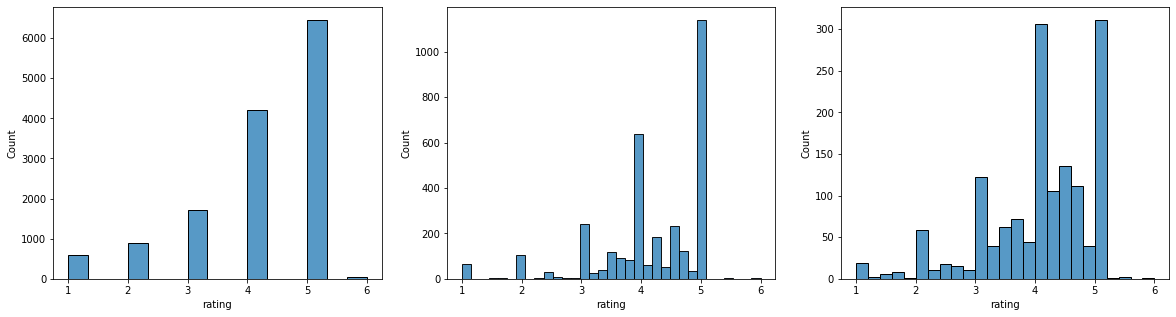

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
rating_train = sns.histplot(data=dtrain, x="rating", bins=15, ax=axes[0])
rating_user = sns.histplot(dtrain.groupby('userID')['rating'].mean(), ax=axes[1])
rating_item = sns.histplot(dtrain.groupby('itemID')['rating'].mean(), ax=axes[2])

#### 2.2 Top-10 highest rating movies 

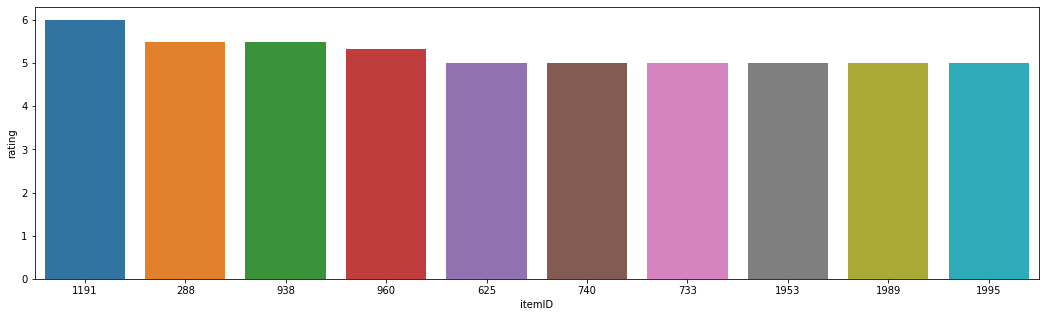

In [ ]:
plt.rcParams['figure.figsize'] = (18, 5)
di_hot = dtrain.groupby('itemID')['rating'].mean().sort_values(ascending = False)[:10]
sns.barplot(x=di_hot.index, y=di_hot, order=di_hot.index)
plt.show()

#### 2.3 Top-10 most popular movies 

Because these items have large frequencies in the training set, we can fit separate models for them one by one if we need to predict their ratings in the test set.

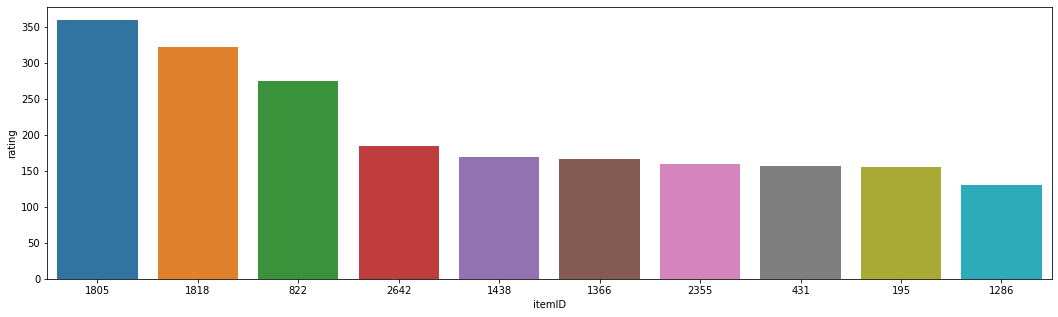

In [ ]:
di_pop = dtrain.groupby('itemID')['rating'].count().sort_values(ascending = False)[:10]
sns.barplot(x=di_pop.index, y=di_pop, order=di_pop.index)
plt.show()

##### 2.4 Top-10 most active users

Similarly, because these users have large frequencies in the training set, we can fit saperate models for them one by one if we need to predict their ratings in the test set.

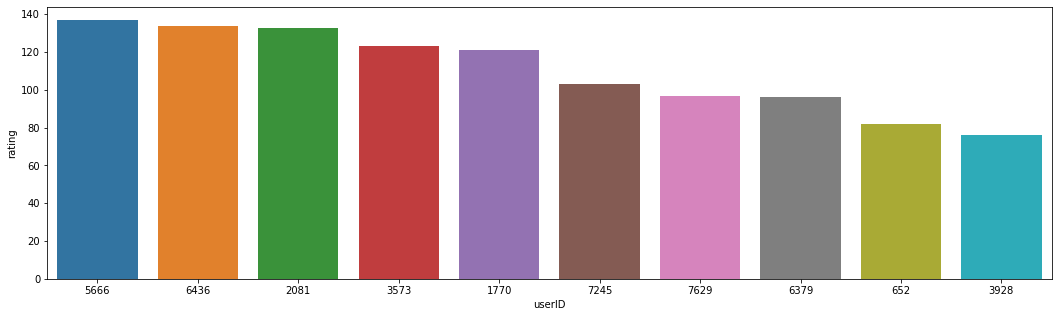

In [ ]:
du_pop = dtrain.groupby('userID')['rating'].count().sort_values(ascending = False)[:10]
sns.barplot(x=du_pop.index, y=du_pop, order=du_pop.index)
plt.show()

### 3. Plots of IDs
Findings:
* The userID and itemID are nearly uniformly distributed.
* The distributions of userID and itemID in the training set and test set are similar.

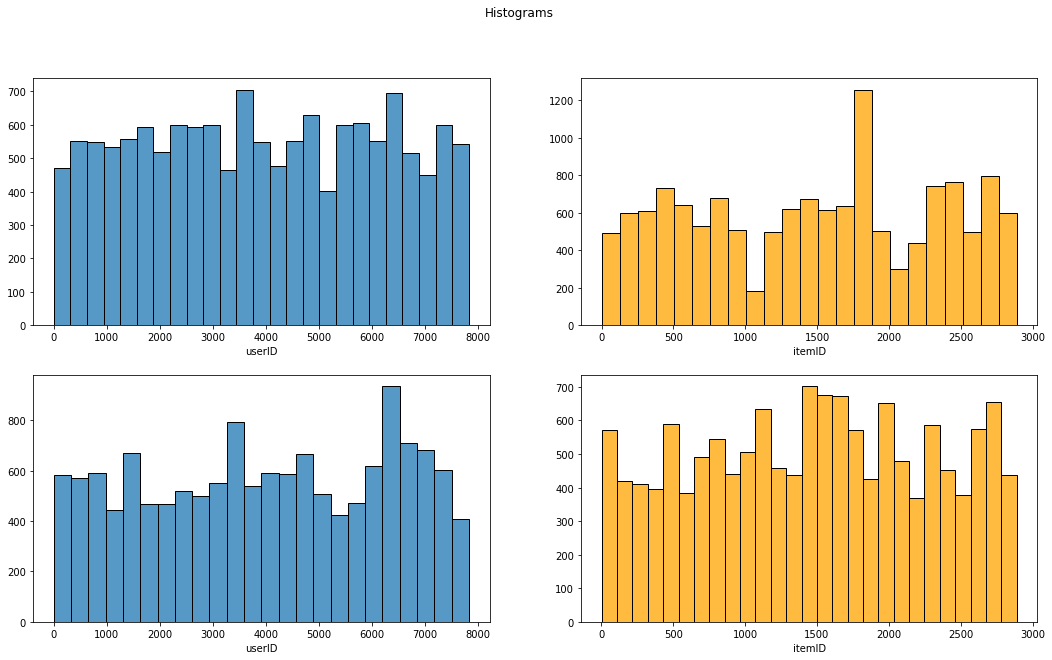

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Histograms')
hist1 = sns.histplot(data=dtrain['userID'], ax=axes[0,0]).set(ylabel='')
hist2 = sns.histplot(dtrain['itemID'], ax=axes[0,1], color='orange').set(ylabel='')
hist3 = sns.histplot(data=dtest['userID'], ax=axes[1,0]).set(ylabel='')
hist4 = sns.histplot(dtest['itemID'], ax=axes[1,1], color='orange').set(ylabel='')

### 4. Side information -- Date

#### 4.1 Date histograms of train set & test set

##### Train set Date
* From 2012-03 to 2013-06.
* Many samples fall in 2012-05, 2012-06, and 2012-07, but few samples fall in edge dates.

##### Test set Date
* From 2013-06 to 2016-10, which is totally non-overlapping with the train data set.
* The proportion is large in 2013 and 2016, but small in 2014 and 2015.
* Looks smoother and more evenly distributed than the train set.

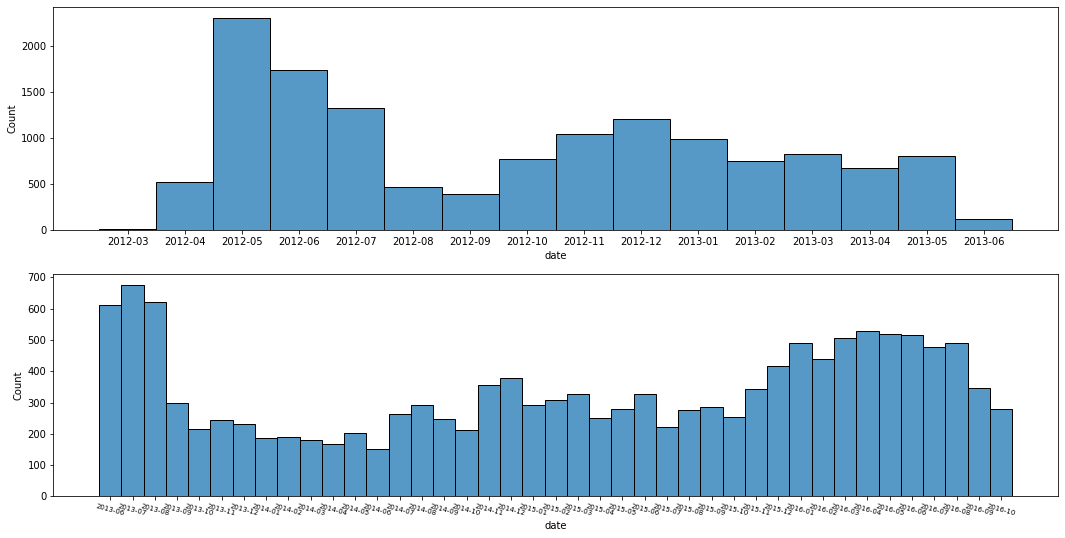

In [ ]:
plt.rcParams['figure.figsize'] = (18, 9)
plt.subplot(2, 1, 1)
date_train = sns.histplot(data=dtrain, x="date", bins=15)
plt.subplot(2, 1, 2)
date_test = sns.histplot(data=dtest, x="date", bins=15)
plt.tick_params(axis='x', labelsize=7)
xtick = plt.xticks(rotation=-15)

#### 4.2 Mean ratings grouped by date & year & month
* According to the second plot, there is not much difference between the years.
* According to the first and third plots, there is slight differences among months.

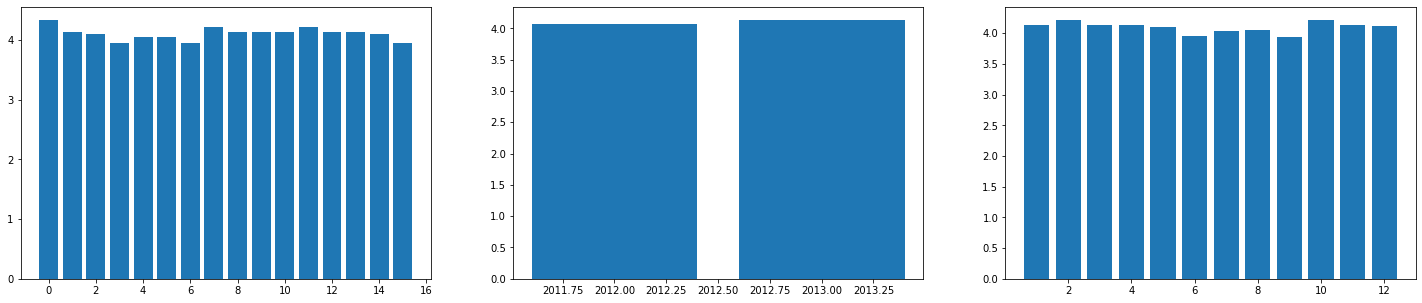

In [ ]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.subplot(1, 3, 1)
date_mean_rating = dtrain.groupby('date')['rating'].mean()
rating_date = plt.bar(x=range(len(date_mean_rating)), height=date_mean_rating)
plt.subplot(1, 3, 2)
rating_year = plt.bar(x=[2012, 2013], height=dtrain.groupby('year')['rating'].mean())
plt.subplot(1, 3, 3)
rating_month = plt.bar(x=np.arange(1, 13), height=dtrain.groupby('month')['rating'].mean())

#### 4.3 Violin plot of ratings grouped by months
The violin plots of each month are quite similar, which means the month doesn't affect the ratings much.

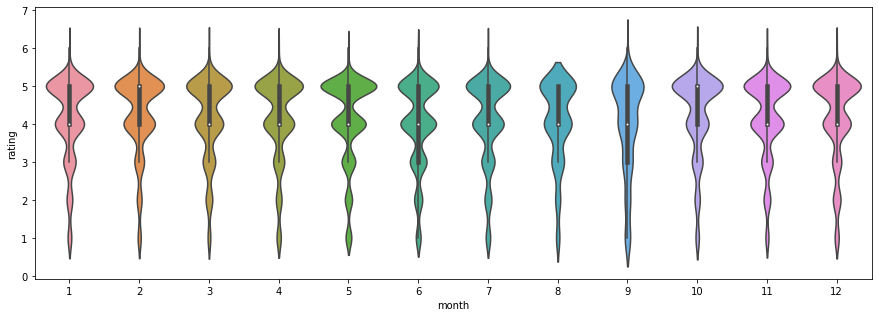

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
month_mean = sns.violinplot(data=dtrain, x="month", y="rating")

### 5. Side information -- Genres

#### 5.1 Genres Histogram
* Rock, Zilin, and Techno are the most frequent in both train set and test set, they're the top-3 popular genres.
* Some genres are very few and can be grouped after dummy processing.

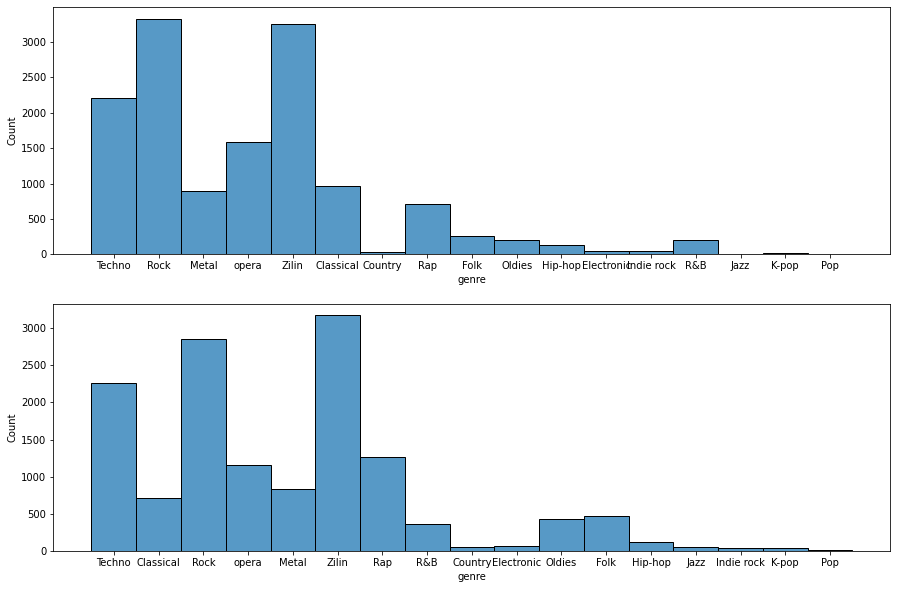

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2, 1, 1)
genre_train = sns.histplot(data=dtrain, x="genre", bins=15)
plt.subplot(2, 1, 2)
genre_test = sns.histplot(data=dtest, x="genre", bins=15)

#### 5.2 Mean ratings histogram grouped by genres
* Mean ratings have a slight difference among genres.
* Indie rock's mean rating is the highest, and that of opera is the lowest.

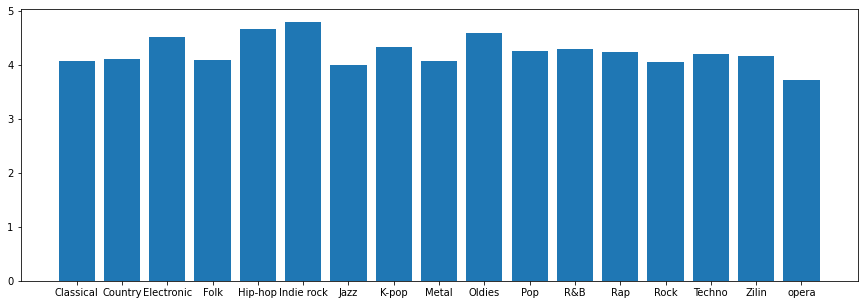

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
genre_mean_rating = dtrain.groupby('genre')['rating'].mean()
rating_genre = plt.bar(x=genre_mean_rating.index, height=genre_mean_rating)

#### 5.3 Violin plot of ratings grouped by genres
Findings:
* Violin plots of some genres are quite different from others, such as **Country**, **Rock**, **Pop**, and so on. 
* **Genre** is an important side information.
* Samples of some genres, such as Indie rock and Pop, need more attention due to their smaller rating variances.

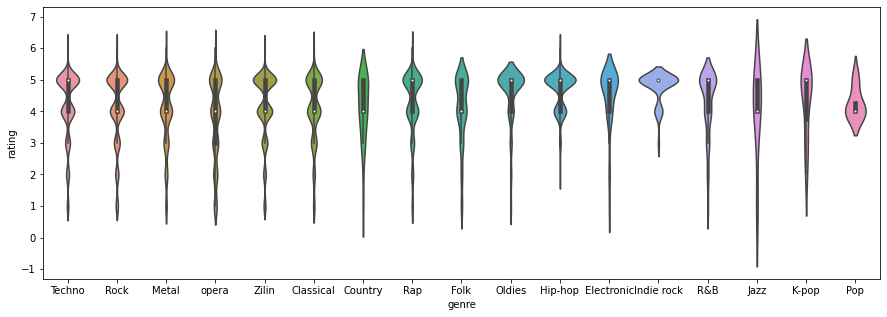

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
genre_mean = sns.violinplot(data=dtrain, x="genre", y="rating")

### 6. Popularity & Mean rating scatter

Findings:
* Ratings of lower frequency (more active or popular) users or items have large variances.
* Ratings of higher frequency users or items (less active or popular) have smaller variances.
* Due to this phenomenon, we can try the `SVD++` method.



#### 6.1 User count - User mean scatter plot

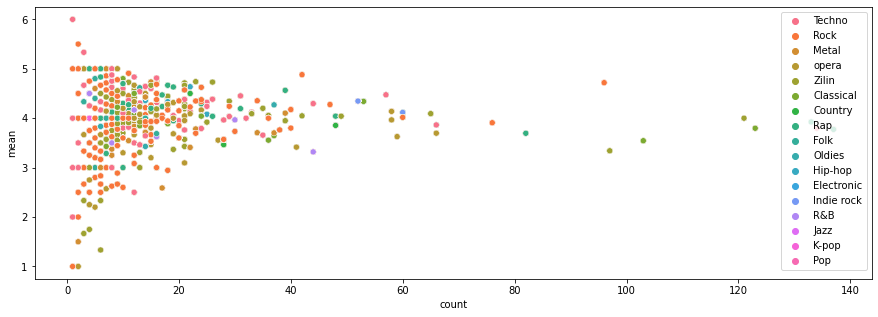

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
user_count_mean = sns.scatterplot(data=dtrain, x="count", y="mean", hue='genre')
leg = plt.legend(loc='upper right')

#### 6.2 Item count - Item mean scatter plot

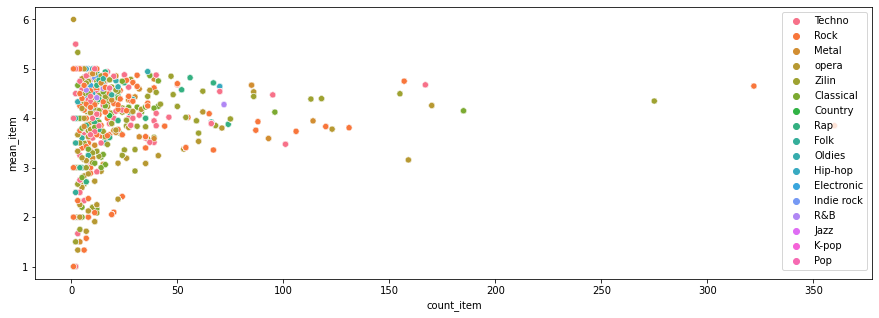

In [ ]:
item_count_mean = sns.scatterplot(data=dtrain, x="count_item", y="mean_item", hue='genre')
leg = plt.legend(loc='upper right')

### 7. User social net
Here we find the **number of fans** of each user, and the **number of users followed by** each user.\
Findings:
  - With the increase of the numbers mentioned above, both of the user mean and item mean tend to increase. Therefore, there can be a relationship between these two numbers and the rating.

In [ ]:
# Find the number of fans of each user
usernet_fans = user_net.merge(user_net.groupby('to').count(), on='to')
usernet_fans.rename(columns={'from_x':'following', 'to':'followed', 'from_y':'fans_count'}, inplace=True)
dtrain = dtrain.merge(usernet_fans[['followed','fans_count']].drop_duplicates(), how='left', left_on='userID', right_on='followed')
dtest = dtest.merge(usernet_fans[['followed','fans_count']].drop_duplicates(), how='left', left_on='userID', right_on='followed')
# Find the number of users followed by each user
usernet_following = user_net.merge(user_net.groupby('from').count(), on='from')
usernet_following.rename(columns={'from':'following', 'to_x':'followed', 'to_y':'following_count'}, inplace=True)
dtrain = dtrain.merge(usernet_following[['following','following_count']].drop_duplicates(), how='left', left_on='userID', right_on='following')
dtest = dtest.merge(usernet_following[['following','following_count']].drop_duplicates(), how='left', left_on='userID', right_on='following')
# Inpute the NAs with 0
from sklearn.impute import SimpleImputer
imp_train = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
dtrain[['fans_count', 'following_count']] = imp_train.fit_transform(dtrain[['fans_count', 'following_count']])
imp_test = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
dtest[['fans_count', 'following_count']] = imp_test.fit_transform(dtest[['fans_count', 'following_count']])

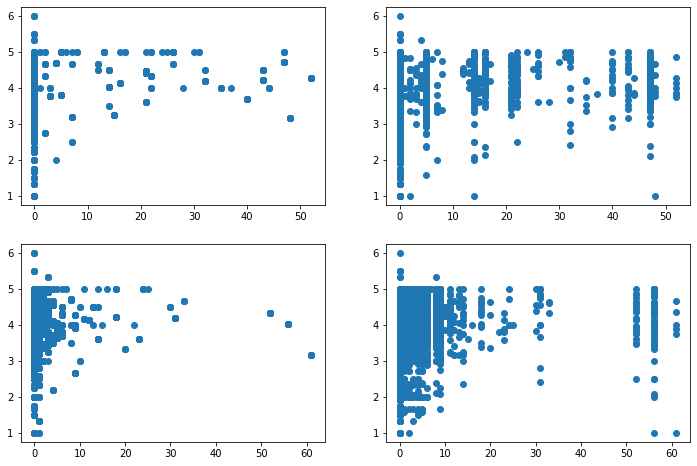

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.subplot(2, 2, 1)
plt1 = plt.scatter(dtrain['following_count'], dtrain['mean'])
plt.subplot(2, 2, 2)
plt2 = plt.scatter(dtrain['following_count'], dtrain['mean_item'])
plt.subplot(2, 2, 3)
plt3 = plt.scatter(dtrain['fans_count'], dtrain['mean'])
plt.subplot(2, 2, 4)
plt4 = plt.scatter(dtrain['fans_count'], dtrain['mean_item'])

## Part 2 Model & Prediction

### Data Preprocessing
In the data preprocessing part, I mainly did 3 steps:
* 1. Map all userID and itemID from string-type codes into integers.
* 2. Encode categorical variables.
* 3. Split sub-train set and valid set. Noting that **the date in the test set are completely non-overalpping with the train set, we need to follow this principle when splitting the valid set as much as possible**. Because: 
  - The date is associated with the proportion of new users or new items. The later the date, the larger the proportion of new users or new items tend to be. 
  - Therefore, we can choose the **last 30 percent of the train set** as our valid set.

In [ ]:
from sklearn import preprocessing
## define categorical and continuous variables
user_cate = ['year', 'month']
item_cate = ['genre']

user_cont = ['count', 'mean']
item_cont = ['count_item', 'mean_item']
    
## user categorical encoding
for cate_tmp in user_cate:
    le_tmp = preprocessing.LabelEncoder()
    le_tmp.fit(pd.concat([dtrain[cate_tmp], dtest[cate_tmp]]))
    dtrain[cate_tmp] = le_tmp.transform(dtrain[cate_tmp])
    dtest[cate_tmp] = le_tmp.transform(dtest[cate_tmp])
for cate_tmp in item_cate:
    le_tmp = preprocessing.LabelEncoder()
    le_tmp.fit(pd.concat([dtrain[cate_tmp], dtest[cate_tmp]]))
    dtrain[cate_tmp] = le_tmp.transform(dtrain[cate_tmp])
    dtest[cate_tmp] = le_tmp.transform(dtest[cate_tmp])

## Split sub train set and valid set
sub_dtrain, dvalid = dtrain[:9658].copy(), dtrain[9658:].copy()
sub_dtrain.reset_index(drop=True, inplace=True)
dvalid.reset_index(drop=True, inplace=True)

## Maintain 'year' and 'month', drop 'date'
sub_dtrain.drop('date',axis=1, inplace=True)
dvalid.drop('date',axis=1, inplace=True)
dtest.drop('date',axis=1, inplace=True)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['userID', 'itemID']].values

sub_train_rating = sub_dtrain['rating'].values
sub_train_rating = np.array(sub_train_rating, dtype=float)
sub_train_pair = sub_dtrain[['userID', 'itemID']].values

valid_rating = dvalid['rating'].values
valid_rating = np.array(valid_rating, dtype=float)
valid_pair = dvalid[['userID', 'itemID']].values

test_pair = dtest[['userID', 'itemID']].values

def rmse(test_rating, pred_rating):
    return np.sqrt(np.mean( (pred_rating - test_rating)**2))

### 1. Baseline Model
As mentioned before, the distributions of mean ratings grouped by userID or itemID are similar to the true distribution, therefore, we firstly try baseline methods including `glb_mean()`, `user_mean()` and `item_mean()` there.
1. Model parameters & performance:
  - Parameters:\
    Global mean: No parameter needs to be tuned.\
    User mean: $K=1$ (The threshold for using the global mean)\
    Item mean: $K=1$ (The threshold for using the global mean)
  - *RMSE_valid*:\
   Global mean: $1.0737$\
   User mean: $1.0699$\
   Item mean: $1.0254$
  - *RMSE_test*:\
  Item mean: $1.0479$\
  Global mean & User mean: Attempts were not submitted.
2. Model strengths:
  * The test RMSE of `item_mean()` is not quite bad, which reflects simple models can be effective for this data set, and item-related information is very important.
3. Model weakness:
  * The *RMSE* is not very small. The methods are too basic, and only including the average information is not enough.
4. Improvement objective:
  * Increase the model complexity by using the sequential model.

#### 1.1 glb_mean & user_mean & item_mean functions

1. Global Mean
$$
\bar{r} = \frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} r_{ui}, \quad \hat{r}_{ui} = \bar{r}
$$

2. User Mean
$$
		\bar{r}_{u} = \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} r_{ui}, \text{ for } u=1, \cdots, n; \quad \hat{r}_{ui} = \bar{r}_u
$$
In this function, we loop for all users
  * Find all records for this user in both the training and testing sets.
  * Compute the average rating for this user in the training set.
  * Predict the rating for this user in the testing set.

3. Item Mean
$$
		\bar{r}_{i} = \frac{1}{|\mathcal{U}_i|} \sum_{u \in \mathcal{U}_i} r_{ui}, \text{ for } i=1, \cdots, m; \quad \hat{r}_{ui} = \bar{r}_i,
$$
In this function, we loop for all items
  * Find all records for this item in both the training and testing sets.
  * Compute the average rating for this item in the training set.
  * Predict the rating for this item in the testing set.

(All codes of functions, implementation, and hyper-parameter tuning process are put into appendix for reference.)

### 2. Sequential Baseline Model
$$
\hat{r}_{ui} = \hat{\rho}_i + \hat{\mu}_u 
$$
1. Steps:
  *  Fit item_mean $\rho_i$ with train_pairs and train_ratings $r_{ui}$
  *  Fit user_mean $\mu_u$ with train_pairs and residuals $r_{ui} - \rho_i$
  *  Predict test ratings with the formula at the top.

2. Model parameters & performance:
  *   Parameter combination：$K_{item}=4$, $K_{user}=2$
  *   *RMSE_valid* $= 1.0294$
  *   *RMSE_test*: $= 1.0433$
3. Model strengths:
  * The *RMSE* decreased along the sequence, which indicates it's reasonable to increase the model complexity. 

4. Model weakness:
  * The *RMSE* isn't small. Only including the ID information is not enough.

5. Improvement objective:
  * Take more information, like side information into consideration.

### 3. Revised Baseline Model
In this method, we add some side information. The difference with the original model lies in the operations when the sample size of this user or item in the train set is less than the threshold $K$.
1. Model parameters & performance:
  - Parameters:\
    User mean: $K=5$ (The threshold for using the month mean)\
    Item mean: $K=6$ (The threshold for using the genre mean)
  - *RMSE_valid*:\
   User mean: $1.0657$\
   Item mean: $1.0195$
  - *RMSE_test*:\
  Item mean: $1.0416$\
  User mean: This attempt isn't submitted.
2. Model strengths:
  * Take the side information of month and genre into consideration, and make an improvement in the RMSE.
3. Model weakness:
  * The test *RMSE* doesn't decrease much. Still need to try other methods.
4. Improvement objective:
  * Try other types of models.
  * Prevent overfitting.

#### 3.1 Revised user_mean & item_mean functions

- `new_user_mean()`: Use the **mean grouped by month**, instead of the global mean, as the predicted value when the sample size in the train set is less than the threshold.
  - E.g. The user whose ID is `6825`, has no record in the train set, and we need to predict for a sample he/she rated in `September`. Therefore, we take the mean of all ratings in `September`, 3.9436, as our predicted rating.
- `new_item_mean()`: Use the **mean grouped by genre**, instead of the global mean, as the predicted value when the sample size in the train set is less than the threshold.
  - E.g. The item whose ID is `2214`, has no record in the train set, and we need to predict its rating. Noted that its genre is `Techno`, we take the mean of all ratings of `Techno` type items, 4.1896, as our predicted rating.

### 4. Two Tower Neural Network Model
In order to increase the model complexity and fit the relationships between ratings and features more accurately, we try the Two-tower neural network model here. In this part, there are three points deserving our attention:
  - Model structure
  - Feature selection: \
    Which feature can we use?
    Whether we can produce some new features?
    Can we do some processing on the existing features?
  - Parameter tuning

1. Model parameters & performance:
  * Parameter combination: 
    - Embedding size $=10$, 
    - Dense size $=10$,
    - Learning rate $=0.001$
    - Epoch $=10$ (In order to prevent **over-fitting**)
  * *RMSE_valid* $= 1.0110$
  * *RMSE_test* $= 1.0295$
2. Model strengths:
  * We use a more complex function, instead of a simple baseline model to predict the rating. This model has a more general applicability.
  * Can aggregate predict ratings of other models, such as baseline models, into the neural network by using them as features.
  * Can effectively extract the with-in effects of user or item features.
3. Model weakness:
  * For some special samples, such as new users or items, or users who have large rating variances, the model's performance is not good enough.
4. Improvement objective:
  * Process those special samples separately on the basis of the Two Tower Neural Network.

#### 4.1 Two-Tower Neural Network Model Function
1. Formula
$$
\hat{r}_{ui} = \rho( \mathbf{p}(u, x_u), \mathbf{q}(i, z_i))
$$

$$
\mathbf{p}(u, x_u) = \psi(x_u^{(1)}, p_{\chi_{u1}^{(2)}}^{(1)}, …,p_{\chi_{u1}^{(2)}}^{(d_{user}^{(2)})})
$$

$$
\mathbf{q}(i, z_i) = \phi(z_i^{(1)}, p_{z_{i1}^{(2)}}^{(1)}, …,p_{z_{i1}^{(2)}}^{(d_{item}^{(2)})})
$$

2. Features
  - user_cate: ['user_id', 'month']
  - item_cate: ['item_id', 'genre']

  - user_cont: ['count', 'mean']
  - item_cont: ['count_item', 'mean_item']

  Note that here we didn't use the feature `'year'`, because:
    * In the EDA part, we found that the year almost doesn't have any effect on ratings.
    * The years in the train set are 2012 and 2013, and the years in the test set are from 2013 to 2016, which are not overlapped with the train set.
    * The year can be a useless feature, so we don't use it here.
  
  Moreover, we impute `NA` values in the `'count'` and `'count_item'` with 0.
3. Model Structure
  - Map categorical variables into embedding layers.
  - Concatenate user continuous variable and embedding layers, and do the same operation to the item one.
  - Dense user vector and item vector into dense layers separately.
  - Concatenate user and item dense layers, and calculate the predicted rating with a joint dense layer.

### 5. Two-Tower Neural Network Model with Bagging
Some ensemble models, such as bagging, are widely known for improving the model's performance considerably. Therefore, we try bagging with bootstrap resampling method there, which can greatly reduce the variance and error of our model.
1. Steps:
  - Resampling ten sub-train sets $Z_1, Z_2, …, Z_{10}$ from the train set with the **bootstrapping method**. All of these sub train sets have the same length as the train set, and each observation in them is sampled with replacement.
  - Fit ten two-tower models $f_1, f_2, …, f_{10}$ for $Z_1, Z_2, …, Z_{10}$ respectively.
  - Calculate the predict ratings $r^{(1)}, r^{(2)}, …, r^{(10)}$ for the test set with ten models $f_1, f_2, …, f_{10}$, and take the mean of these ten rating vectors as the final predict rating.
$$\quad \hat{r}_{ui} = \bar{r}_{ui} = \frac{1}{10} \sum_{m=1}^{10} r_{ui}^{(m)}$$
2. Model performance:
  * *RMSE_valid* $= 1.0108$
  * *RMSE_test* $= 1.0258$
3. Model strengths:
  * This ensemble can effectively reduce the model's variance and error.
4. Model weakness:
  * For some special samples, such as new users or items, or users who have large rating variances, the model's performance is not good enough.
5. Improvement objective:
  * Process those special samples separately on the basis of the Two Tower Neural Network.

### 6. Process the top-10 popular items separately
As mentioned above, our model can't fit very well for some special samples. In addition, in the EDA part we have found the top-10 most popular items, which means if we need to predict for any of these 10 items, we have enough records in the train set. Therefore, we can **try to fit different models for these 10 items separately**, which may be more accurate.
1. Steps:
- Find the top-10 poplular items in the train set.
- Loop for these 10 items:
  - Check whether we need to predict for this item in the test. If yes, continue; if no, pass.
  - Find all records of this item in the train set. Fit a Two-Tower model with these records.
  - Predict ratings for this item with this model, and replace the corresponding ratings with this new one.

2. Model performance:
  * *RMSE_valid* $= 1.0061$
  * *RMSE_test* $= 1.0236$
2. Model strengths:
  * This method can help us improve the ratings more accurately for a proportion of samples in the test set.
3. Model weakness & Improvement objective:
  * Try to take the user's social net into consideration.

  

### 7. Two-Tower NN Model with Bagging & User Social Net
Here we take the number of fans of each user, and the number of users followed by each user into consideration. We just use them as user continuous features.
2. Model performance:
  * *RMSE_valid* $= 1.0011$
  * *RMSE_test* $= 1.0229$
2. Model strengths:
  * This model takes all side informations into consideration and its RMSE on the test set decreases a bit.
  * The ensamble model used can effectively reduce the model's variance and error, and make this model more robust.
  * This model aggregates predict ratings of other models, and has a more general applicability.


## Part 3 Predict Results

Student ID: 1155157075\
Last three digits: 075\
Find the 75th record in the test set:

In [ ]:
print(f"The 75th userID: {dtest.loc[75, 'userID']}, itemID: {dtest.loc[75, 'itemID']}, pred rating: {pred[75]}")

The 75th userID: 4406, itemID: 111, pred rating: 3.6596038341522217


Potential top-5 preferred items: [2056, 2657, 1818, 1764, 431]

In [ ]:
dtest.groupby('itemID')['pred'].mean().sort_values(ascending = False)[:5]

itemID
2056    5.231417
2657    5.170112
1818    5.059242
1764    5.036437
431     5.023879
Name: pred, dtype: float64

## Part 4 Appendix

### 4.1 Baseline Model

#### 4.1.1 Baseline Functions

In [ ]:
def glb_mean(train_rating, test_pair):
    pred = train_rating.mean() * np.ones(len(test_pair))
    return pred

def user_mean(train_pair, train_rating, test_pair, k=5):
    n_user = max(train_pair[:,0].max(), test_pair[:,0].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for u in range(n_user):
        # find the index for both train and test for user_id = u
        ind_test = np.where(test_pair[:,0] == u)[0]
        ind_train = np.where(train_pair[:,0] == u)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < k:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

def item_mean(train_pair, train_rating, test_pair, k=5):
    n_item = max(train_pair[:,1].max(), test_pair[:,1].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for i in range(n_item):
        # find the index for both train and test for item_id = i
        ind_test = np.where(test_pair[:,1] == i)[0]
        ind_train = np.where(train_pair[:,1] == i)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < k:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

#### 4.1.2 Baseline Model Implementation & Hyper-parameter Tuning

In [ ]:
print('**********Baseline Model**********')
glb_pred = glb_mean(sub_train_rating, valid_pair)
print(f'RMSE of global mean: {rmse(glb_pred, valid_rating)}')
user_pred = user_mean(sub_train_pair, sub_train_rating, valid_pair)
print(f'RMSE of user mean: {rmse(user_pred, valid_rating)}')
item_pred = item_mean(sub_train_pair, sub_train_rating, valid_pair)
print(f'RMSE of item mean: {rmse(item_pred, valid_rating)}')

**********Baseline Model**********
RMSE of global mean: 1.073657770286826
RMSE of user mean: 1.069920036452371
RMSE of item mean: 1.0253809875620503


In [ ]:
user_cv_result = {'K': [], 'valid_rmse': []}
item_cv_result = {'K': [], 'valid_rmse': []}

for k in range(1, 8):
  user_pred = user_mean(sub_train_pair, sub_train_rating, valid_pair)
  item_pred = item_mean(sub_train_pair, sub_train_rating, valid_pair)
  user_cv_result['K'].append(k)
  user_cv_result['valid_rmse'].append(rmse(valid_rating, user_pred))
  item_cv_result['K'].append(k)
  item_cv_result['valid_rmse'].append(rmse(valid_rating, item_pred))

user_cv_result = pd.DataFrame.from_dict(user_cv_result)
user_best_ind = user_cv_result['valid_rmse'].argmin()
user_best_model = user_cv_result.loc[user_best_ind]
print('\nuser_mean best model:')
print(f'{user_best_model}\n')

item_cv_result = pd.DataFrame.from_dict(item_cv_result)
item_best_ind = item_cv_result['valid_rmse'].argmin()
item_best_model = item_cv_result.loc[item_best_ind]
print('\nitem_mean best model:')
print(f'{item_best_model}\n')


user_mean best model:
K             1.00000
valid_rmse    1.06992
Name: 0, dtype: float64


item_mean best model:
K             1.000000
valid_rmse    1.025381
Name: 0, dtype: float64



### 4.2. Sequential Baseline Model

#### 4.2.1 Sequential Model Implementation & Hyper-parameter Tuning

**********Mean Sequential Model**********

Sequential Baseline Best model:
K1            4.000000
K2            2.000000
valid_rmse    1.029434
Name: 12, dtype: float64



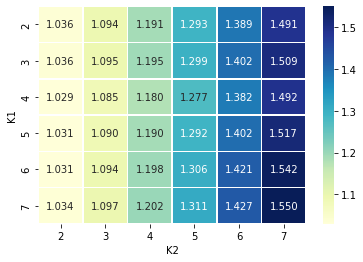

In [ ]:
cv_result = {'K1': [], 'K2': [], 'valid_rmse': []}

print('**********Mean Sequential Model**********')
for k1 in range(2, 8):
    pred_rating = item_mean(sub_train_pair, sub_train_rating, valid_pair, k=k1)
  
    for k2 in range(2, 8):
        res_rating = sub_train_rating - item_mean(sub_train_pair, sub_train_rating, sub_train_pair, k=k1)
        pred_res_item = user_mean(sub_train_pair, res_rating, valid_pair, k=k2)
        pred_rating = pred_rating + pred_res_item
      
        cv_result['K1'].append(k1)
        cv_result['K2'].append(k2)
        cv_result['valid_rmse'].append(rmse(valid_rating, pred_rating))

cv_result = pd.DataFrame.from_dict(cv_result)
best_ind = cv_result['valid_rmse'].argmin()
best_model = cv_result.loc[best_ind]
cv_pivot = cv_result.pivot("K1", "K2", "valid_rmse")
print('\nSequential Baseline Best model:')
print(f'{best_model}\n')
map = sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()

### 4.3 Revised Baseline Model

#### 4.3.1 Revised Baseline Functions

In [ ]:
def new_user_mean(train_pair, train_rating, dtrain, test_pair, dtest, k=5, res=False):
    n_user = max(train_pair[:,0].max(), test_pair[:,0].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for i in range(n_user):
        # find the index for both train and test for item_id = i
        ind_test = np.where(test_pair[:,0] == i)[0]
        ind_train = np.where(train_pair[:,0] == i)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < k:
            for ind in ind_test:
                month = dtest.loc[ind, 'month']
                if res:
                    pred[ind] = dtrain[dtrain['month']==month]['res_nn'].mean()
                    if str(pred[ind]) == 'nan':
                        pred[ind] = 0
                else:
                    pred[ind] = dtrain[dtrain['month']==month]['rating'].mean()
                    if month == 0:
                        pred[ind] = 4.12968591691996
                    elif month == 1:
                        pred[ind] = 4.216689098250336
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

def new_item_mean(train_pair, train_rating, dtrain, test_pair, dtest, k=5, res=False):
    n_item = max(train_pair[:,1].max(), test_pair[:,1].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for i in range(n_item):
        # find the index for both train and test for item_id = i
        ind_test = np.where(test_pair[:,1] == i)[0]
        ind_train = np.where(train_pair[:,1] == i)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < k:
            #pred[ind_test] = glb_mean_value
            for ind in ind_test:
                genre = dtest.loc[ind, 'genre']
                if res:
                    pred[ind] = dtrain[dtrain['genre']==genre]['res_nn'].mean()
                    if str(pred[ind]) == 'nan':
                        pred[ind] = 0
                else:
                    pred[ind] = dtrain[dtrain['genre']==genre]['rating'].mean()
                    if str(pred[ind]) == 'nan':
                        pred[ind] = 4.5
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

In [ ]:
def user_count(train_pair, test_pair):
    n_user = max(train_pair[:,0].max(), test_pair[:,0].max())+1
    count = np.zeros(len(test_pair))
    for u in range(n_user):
        ind_test = np.where(test_pair[:,0] == u)[0]
        ind_train = np.where(train_pair[:,0] == u)[0]
        if len(ind_test) == 0:
            continue
        else:
            count[ind_test] = len(ind_train)
    return count

def item_count(train_pair, test_pair):
    n_item = max(train_pair[:,1].max(), test_pair[:,1].max())+1
    count = np.zeros(len(test_pair))
    for u in range(n_item):
        ind_test = np.where(test_pair[:,1] == u)[0]
        ind_train = np.where(train_pair[:,1] == u)[0]
        if len(ind_test) == 0:
            continue
        else:
            count[ind_test] = len(ind_train)
    return count

#### 4.3.2 Revised Baseline Model Implementation & Hyper-parameter Tuning

In [ ]:
user_cv_result = {'K': [], 'valid_rmse': []}
item_cv_result = {'K': [], 'valid_rmse': []}

for k in range(1, 8):
  user_pred = new_user_mean(sub_train_pair, sub_train_rating, sub_dtrain, valid_pair, dvalid, k=k)
  item_pred = new_item_mean(sub_train_pair, sub_train_rating, sub_dtrain, valid_pair, dvalid, k=k)
  user_cv_result['K'].append(k)
  user_cv_result['valid_rmse'].append(rmse(valid_rating, user_pred))
  item_cv_result['K'].append(k)
  item_cv_result['valid_rmse'].append(rmse(valid_rating, item_pred))

user_cv_result = pd.DataFrame.from_dict(user_cv_result)
user_best_ind = user_cv_result['valid_rmse'].argmin()
user_best_model = user_cv_result.loc[user_best_ind]
print('\nnew_user_mean best model:')
print(f'{user_best_model}\n')

item_cv_result = pd.DataFrame.from_dict(item_cv_result)
item_best_ind = item_cv_result['valid_rmse'].argmin()
item_best_model = item_cv_result.loc[item_best_ind]
print('\nnew_item_mean best model:')
print(f'{item_best_model}\n')


new_user_mean best model:
K             5.000000
valid_rmse    1.065697
Name: 4, dtype: float64


new_item_mean best model:
K             6.000000
valid_rmse    1.019481
Name: 5, dtype: float64



### 4.4 Two-Tower Neural Network Model 

#### 4.4.1 Two-Tower Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class ori_TTowerRS(keras.Model):
    def __init__(self, num_users, num_movies, num_genre, num_month, embedding_size, dense_size, **kwargs):
        super(ori_TTowerRS, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.num_genre = num_genre
        self.num_month = num_month
        ## Embedding layers
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )      
        self.genre_embedding = layers.Embedding(
            num_genre,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.month_embedding = layers.Embedding(
            num_month,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        ##  Mapping layers
        self.user_dense = layers.Dense(dense_size, name='user_dense', activation='relu')
        self.item_dense = layers.Dense(dense_size, name='item_dense', activation='relu')
        self.joint_dense = layers.Dense(dense_size, name='joint_dense', activation='relu')
        self.out_dense = layers.Dense(1, name='out_dense', activation='linear')

    def call(self, inputs):
        ## cate/cont data
        user_cont_feat, item_cont_feat, user_cate_feat, item_cate_feat = inputs[0], inputs[1], inputs[2], inputs[3]
        ## user embedding - user: [userID, month]
        user_vec = self.user_embedding(user_cate_feat[:, 0])
        month_vec = self.month_embedding(user_cate_feat[:, 1])

        ## movie embedding - item: [itemID, genre]
        movie_vec = self.movie_embedding(item_cate_feat[:, 0])
        genre_vec = self.genre_embedding(item_cate_feat[:, 1])

        ## user/item dense mapping
        user_all_vec = layers.Concatenate()([user_cont_feat, user_vec, month_vec])
        item_all_vec = layers.Concatenate()([item_cont_feat, movie_vec, genre_vec])
        user_dense_vec = self.user_dense(user_all_vec)
        item_dense_vec = self.item_dense(item_all_vec)

        ## joint dense
        joint_vec = layers.Concatenate()([user_dense_vec, item_dense_vec])
        joint_vec = self.joint_dense(joint_vec)
        out = self.out_dense(joint_vec)
        return out

#### 4.4.2 Two-Tower Model Implementation & Hyper-parameter Tuning

In [ ]:
dtrain['count'] = user_count(train_pair, train_pair)
dtrain['count_item'] = item_count(train_pair, train_pair)
dtrain['mean'] = new_user_mean(train_pair, train_rating, dtrain, train_pair, dtrain)
dtrain['mean_item'] = new_item_mean(train_pair, train_rating, dtrain, train_pair, dtrain)

sub_dtrain['count']  = user_count(sub_train_pair, sub_train_pair)
sub_dtrain['count_item'] = item_count(sub_train_pair, sub_train_pair)
sub_dtrain['mean'] = new_user_mean(sub_train_pair, sub_train_rating, sub_dtrain, sub_train_pair, sub_dtrain)
sub_dtrain['mean_item'] = new_item_mean(sub_train_pair, sub_train_rating, sub_dtrain, sub_train_pair, sub_dtrain)

dvalid['count'] = user_count(sub_train_pair, valid_pair)
dvalid['count_item']= item_count(sub_train_pair, valid_pair)
dvalid['mean'] = new_user_mean(sub_train_pair, sub_train_rating, sub_dtrain, valid_pair, dvalid)
dvalid['mean_item'] = item_mean(sub_train_pair, sub_train_rating, valid_pair)

dtest['count'] = user_count(train_pair, test_pair)
dtest['count_item'] = item_count(train_pair, test_pair)
dtest['mean'] = new_user_mean(train_pair, train_rating, dtrain, test_pair, dtest)
dtest['mean_item'] = new_item_mean(train_pair, train_rating, dtrain, test_pair, dtest)

In [ ]:
train_input = [dtrain[['count', 'mean']].values,
               dtrain[['count_item', 'mean_item']].values,
               dtrain[['userID', 'month']].astype(int).values,
               dtrain[['itemID', 'genre']].astype(int).values,
               ]
sub_train_input = [sub_dtrain[['count', 'mean']].values,
               sub_dtrain[['count_item', 'mean_item']].values,
               sub_dtrain[['userID', 'month']].astype(int).values,
               sub_dtrain[['itemID', 'genre']].astype(int).values,
               ]
valid_input = [dvalid[['count', 'mean']].values,
               dvalid[['count_item', 'mean_item']].values,
               dvalid[['userID', 'month']].astype(int).values,
               dvalid[['itemID', 'genre']].astype(int).values,
               ]
test_input = [dtest[['count', 'mean']].values,
               dtest[['count_item', 'mean_item']].values,
               dtest[['userID', 'month']].astype(int).values,
               dtest[['itemID', 'genre']].astype(int).values,
               ]

In [ ]:
num_cate = np.max(dtrain[['genre', 'year', 'month']].append(dtest[['genre', 'year', 'month']]), axis=0) + 1
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

model = ori_TTowerRS(num_users=n_user, num_movies=n_item, 
                 num_genre=num_cate[0], num_month=num_cate[2],
                 embedding_size=10, dense_size=10)
metrics = [
    #keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='min', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=sub_train_input,
    y=sub_dtrain['rating'].astype(float).values[:,np.newaxis],
    batch_size=64,
    epochs=50,
    verbose=0,
    callbacks = callbacks,
    validation_data=(valid_input, valid_rating)
)
model.evaluate(valid_input, dvalid['rating'].astype(float).values[:,np.newaxis])

Restoring model weights from the end of the best epoch: 22.
Epoch 27: early stopping
133/133 [==============================] - 1s 2ms/step - loss: 1.0978 - rmse: 1.0110


[1.0978347063064575, 1.0109833478927612]

### 4.5 Two-Tower Neural Network Model with Bagging

#### 4.5.1 TTower NN Model Implementation

In [ ]:
ori_boot_pred = pd.DataFrame(columns=['0', '1', '2', '3', '4', 
                                  '5', '6', '7', '8', '9'])
num_cate = np.max(dtrain[['genre', 'year', 'month']].append(dtest[['genre', 'year', 'month']]), axis=0) + 1
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

metrics = [
    keras.metrics.RootMeanSquaredError(name='rmse')
]
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='min', baseline=None, restore_best_weights=True)]

for i in range(10):
    print(f'{i}th boot strap')
    ## Data Preperation
    ind = np.random.choice(range(len(sub_dtrain)), len(sub_dtrain), replace=True)
    new_dtrain = sub_dtrain.iloc[ind, :]
    
    new_train_input = [new_dtrain[['count', 'mean']].values,
               new_dtrain[['count_item', 'mean_item']].values,
               new_dtrain[['userID', 'month']].astype(int).values,
               new_dtrain[['itemID', 'genre']].astype(int).values
               ]
    
    model = ori_TTowerRS(num_users=n_user, num_movies=n_item, 
                 num_genre=num_cate[0], num_month=num_cate[2],
                 embedding_size=10, dense_size=10)
    model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
    )
    history = model.fit(
    x=new_train_input,
    y=new_dtrain['rating'].astype(float).values[:,np.newaxis],
    batch_size=64,
    epochs=10,
    verbose=0,
    callbacks = callbacks,
    validation_data=(valid_input, valid_rating)
    )
    
    ori_boot_pred[str(i)] = model.predict(valid_input).flatten()

pred = np.mean(ori_boot_pred, axis=1)
dvalid['boot_pred_nn'] = pred
print(f'RMSE of bagging TTower model: {rmse(valid_rating, pred)}')

0th boot strap
133/133 [==============================] - 0s 1ms/step
1th boot strap
133/133 [==============================] - 0s 2ms/step
2th boot strap
133/133 [==============================] - 0s 2ms/step
3th boot strap
133/133 [==============================] - 0s 2ms/step
4th boot strap
133/133 [==============================] - 0s 2ms/step
5th boot strap
133/133 [==============================] - 0s 2ms/step
6th boot strap
133/133 [==============================] - 0s 2ms/step
7th boot strap
133/133 [==============================] - 0s 1ms/step
8th boot strap
133/133 [==============================] - 0s 1ms/step
9th boot strap
133/133 [==============================] - 0s 2ms/step
RMSE of bagging TTower model: 1.0108280485782108


### 4.6 Process the top-10 popular items separately

#### 4.6.1 Implementation

In [ ]:
pop_items = sub_dtrain.groupby('itemID')['rating'].count().sort_values(ascending = False)[:10]

popitem_list = []
for item in pop_items.index:
    if item in set(dvalid['itemID']):
        popitem_list.append(item)

for item in popitem_list:
    sub_dtrain_new = sub_dtrain[sub_dtrain['itemID']==item]
    dvalid_new = dvalid[dvalid['itemID']==item]
    
    new_sub_train_input = [sub_dtrain_new[['count', 'mean']].values,
               sub_dtrain_new[['count_item', 'mean_item']].values,
               sub_dtrain_new[['userID', 'month']].astype(int).values,
               sub_dtrain_new[['itemID', 'genre']].astype(int).values,
               ]
    new_valid_input = [dvalid_new[['count', 'mean']].values,
                   dvalid_new[['count_item', 'mean_item']].values,
                   dvalid_new[['userID', 'month']].astype(int).values,
                   dvalid_new[['itemID', 'genre']].astype(int).values,
                   ]
    model = ori_TTowerRS(num_users=n_user, num_movies=n_item, 
                 num_genre=num_cate[0], num_month=num_cate[2],
                 embedding_size=10, dense_size=10)
    metrics = [
        keras.metrics.RootMeanSquaredError(name='rmse')
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(1e-2), 
        loss=tf.keras.losses.MeanSquaredError(), 
        metrics=metrics
    )
    callbacks = [keras.callbacks.EarlyStopping( 
        monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
        mode='min', baseline=None, restore_best_weights=True)]

    history = model.fit(
        x=new_sub_train_input,
        y=sub_dtrain_new['rating'].astype(float).values[:,np.newaxis],
        batch_size=64,
        epochs=20,
        verbose=1,
        callbacks = callbacks
    )
    dvalid.loc[dvalid['itemID']==item,'boot_pred_nn'] = model.predict(new_valid_input).flatten()

In [ ]:
print(f"RMSE of NN with items processed: {rmse(dvalid['rating'], dvalid['boot_pred_nn'])}")

RMSE of NN with items processed: 1.0060895164532115


### 4.7 Two-Tower NN Model with Bagging & User Social Net

#### 4.7.1 Implementation

In [ ]:
train_input = [dtrain[['count', 'mean', 'following_count', 'fans_count']].values,
               dtrain[['count_item', 'mean_item']].values,
               dtrain[['userID', 'month']].astype(int).values,
               dtrain[['itemID', 'genre']].astype(int).values,
               ]
sub_train_input = [sub_dtrain[['count', 'mean', 'following_count', 'fans_count']].values,
               sub_dtrain[['count_item', 'mean_item']].values,
               sub_dtrain[['userID', 'month']].astype(int).values,
               sub_dtrain[['itemID', 'genre']].astype(int).values,
               ]
valid_input = [dvalid[['count', 'mean', 'following_count', 'fans_count']].values,
               dvalid[['count_item', 'mean_item']].values,
               dvalid[['userID', 'month']].astype(int).values,
               dvalid[['itemID', 'genre']].astype(int).values,
               ]
test_input = [dtest[['count', 'mean', 'following_count', 'fans_count']].values,
               dtest[['count_item', 'mean_item']].values,
               dtest[['userID', 'month']].astype(int).values,
               dtest[['itemID', 'genre']].astype(int).values,
               ]

In [ ]:
ori_boot_pred = pd.DataFrame(columns=['0', '1', '2', '3', '4', 
                                  '5', '6', '7', '8', '9'])
num_cate = np.max(dtrain[['genre', 'year', 'month']].append(dtest[['genre', 'year', 'month']]), axis=0) + 1
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

metrics = [
    keras.metrics.RootMeanSquaredError(name='rmse')
]
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='min', baseline=None, restore_best_weights=True)]

for i in range(10):
    print(f'{i}th boot strap')
    ## Data Preperation
    ind = np.random.choice(range(len(sub_dtrain)), len(sub_dtrain), replace=True)
    new_dtrain = sub_dtrain.iloc[ind, :]
    
    new_train_input = [new_dtrain[['count', 'mean', 'following_count', 'fans_count']].values,
               new_dtrain[['count_item', 'mean_item']].values,
               new_dtrain[['userID', 'month']].astype(int).values,
               new_dtrain[['itemID', 'genre']].astype(int).values
               ]
    
    model = ori_TTowerRS(num_users=n_user, num_movies=n_item, 
                 num_genre=num_cate[0], num_month=num_cate[2],
                 embedding_size=10, dense_size=10)
    model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
    )
    history = model.fit(
    x=new_train_input,
    y=new_dtrain['rating'].astype(float).values[:,np.newaxis],
    batch_size=64,
    epochs=10,
    verbose=0,
    callbacks = callbacks,
    validation_data=(valid_input, valid_rating)
    )
    
    ori_boot_pred[str(i)] = model.predict(valid_input).flatten()

pred = np.mean(ori_boot_pred, axis=1)
print(f'RMSE of bagging&user social net TTower model: {rmse(valid_rating, pred)}')

0th boot strap
133/133 [==============================] - 0s 2ms/step
1th boot strap
133/133 [==============================] - 0s 1ms/step
2th boot strap
133/133 [==============================] - 0s 1ms/step
3th boot strap
133/133 [==============================] - 0s 2ms/step
4th boot strap
133/133 [==============================] - 0s 2ms/step
5th boot strap
133/133 [==============================] - 0s 2ms/step
6th boot strap
133/133 [==============================] - 0s 2ms/step
7th boot strap
133/133 [==============================] - 0s 2ms/step
8th boot strap
133/133 [==============================] - 0s 1ms/step
9th boot strap
133/133 [==============================] - 0s 1ms/step
RMSE of bagging&user social net TTower model: 1.0011321182317339
